# Introduction to atomman: Semidiscrete Variational Peierls-Nabarro

__Lucas M. Hale__, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), _Materials Science and Engineering Division, NIST_.
    
[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 

## 1. Introduction

This Notebook outlines how to calculate semidiscrete variational Peierls-Nabarro models of dislocation disregistries.  This calculation method gives a prediction for a dislocation structure using only the material's elastic constants and the generalized stacking fault energy map associated with the dislocation's slip plane. 

**NOTE:** the calculation process is complex and may be refined over time resulting in changes to the involved functions and classes.  For this reason, be aware of the atomman version used.

**Library Imports**

In [1]:
# Standard Python libraries
from __future__ import (absolute_import, print_function,
                        division, unicode_literals)
import os
import datetime

# http://www.numpy.org/
import numpy as np

# https://github.com/usnistgov/atomman
import atomman as am
import atomman.unitconvert as uc

# https://matplotlib.org/
import matplotlib.pyplot as plt
%matplotlib inline

# Show atomman version
print('atomman version =', am.__version__)

# Show date of Notebook execution
print('Notebook executed on', datetime.date.today())

atomman version = 1.2.4
Notebook executed on 2019-02-06


### 1.1. Theory

The equations and calculations used are based on the original semidiscrete variational Peierls-Nabarro by Bulatov, et. al [[1][1], [2][2], [3][3]], as well as additional and alternate terms [[4][4], [5][5], [6][6], [7][7]]. The discussion here is very brief and it is left to the reader to see the referenced papers for more details.
 
#### 1.1.1. Disregistry and dislocation density

The disregistry of a dislocation, $\delta_i$, is defined as the difference in the displacement just above and below the slip plane taken as a function of the coordinate $\xi$ that is along the slip plane and perpendicular to the dislocation line.

$$ \delta_i(\xi) = u_i^+(\xi) - u_i^-(\xi) $$

A dislocation density, $\rho_i$, is also defined that can be thought of as the infinitesimal Burgers vector of the dislocation at any specific $\xi$ point, and is related to $\delta_i$ as

$$ \rho_i(\xi) = \frac{d \delta_i(\xi)}{d \xi} $$

For a slip plane containing a single dislocation in an otherwise infinite medium, $\delta_i$ and $\rho_i$ can be related to the dislocation's Burgers vector, $b_i$

$$ \delta_i(\infty) - \delta_i(-\infty) = b_i $$

$$ \int_{-\infty}^{+\infty}{\rho_i(\xi) d\xi} = b_i $$

#### 1.1.2.  Semidiscrete variational Peierls-Nabarro model

The semidiscrete variational Peierls-Nabarro (SDVPN) model expresses the energy of a dislocation as a summation of different energy terms, each of which is a function of $\delta_i$.  Here, the general dislocation energy equation is

$$ U_{dislocation} = U_{elastic} + U_{misfit} + U_{stress} + U_{surface} + U_{nonlocal} $$

Each of the energy terms is expressed with a discrete formulation that assumes the disregistry is a step function evaluated at certain points and constant in between. The disregistry is evaluated at regular intervals, with $\Delta \xi$ typically corresponding to a spacing of atomic columns along the $\xi$ direction giving the calculation a discreteness corresponding to an actual atomic discreteness.  The SDVPN model then solves for the disregistry at the evaluated $\xi$ points that minimizes the dislocation's energy.

#### 1.1.3 Elastic energy

The elastic energy is due to the elastic energy of the dislocation.  It contains two components: a configuration-dependent part associated with the interaction of the dislocation at one position interacting with the dislocation at another point, and a configuration-independent part associated with the dislocation's long-range strain field. The elastic energy is expressed as

$$ U_{elastic} = \frac{1}{4\pi} \sum_i{\left[ \sum_j{\left( \chi(i, j, \Delta \xi) K_{lm} \rho_l[i] \rho_m[j] \right)} \right]} + \frac{1}{4\pi} K_{lm} b_l b_m \ln{(L)}, $$

where $i$ and $j$ are integer indexes of the $\xi$ evaluation points, i.e. $\xi[i+1] = \xi[i] + \Delta \xi$, $K_{lm}$ is the dislocation's energy coefficient tensor, $L$ is a cutoff radius for the long-range configuration-independent elastic energy, and $\chi$ is a multiplicative factor related to the distance between points $\xi[i]$ and $\xi[j]$ given by

$$ \chi(i,j,\Delta \xi) = \frac{3}{2} \Delta \xi^2 + \psi(i-1,j-1,\Delta \xi) + \psi(i,j,\Delta \xi) - \psi(i,j-1,\Delta \xi) - \psi(j,i-1,\Delta \xi), $$

$$ \psi(i,j,\Delta \xi) = \frac{1}{2} (i-j)^2 \Delta \xi^2 \ln{(|i-j|\Delta \xi)}. $$

The dislocation density, $\rho_l$, is obtained from the discrete $\delta_l$ as

$$ \rho_l[i] = \frac{\delta_l[i] - \delta_l[i-1]}{\Delta \xi} $$

**NOTE:** slightly different forms for $U_{elastic}$ are found in the references due to how the different authors define the energy coefficient tensor, $K_{lm}$.  Here, $K_{lm}$ is defined such that in the isotropic case $K_{33} = K_{screw} = \mu$, and $K_{11} = K_{edge} = \frac{\mu}{1-\nu}$ where $\mu$ is the shear modulus and $\nu$ is the Poisson's ratio.

#### 1.1.4. Misfit energy

The misfit energy arises from the disregistry within the dislocation spreading coinciding with crystallographically unfavorable configurations.  This energy is calculated by mapping the dislocation's disregistry onto a generalized stacking fault energy map, i.e $\gamma$ surface

$$ U_{misfit} = \sum_i \gamma(\delta_l[i]) \Delta \xi. $$

#### 1.1.5. Stress energy

The stress energy computes the energy due to an externally applied stress, $\tau_{ij}$, interacting with the dislocation line.  Two forms have been used in SDVPN models: the original full stress form

$$ U_{stress} = -\frac{1}{2} \sum_i{ \left[ \left(\xi[i]^2 - \xi[i-1]^2 \right) \rho_l[i] \tau_{2l} \right]}, $$

and a truncated form introduced by ??

$$ U_{stress} = -\frac{1}{2} \sum_i{ \left[ \tau_{2l} \left(\delta_l[i] + \delta_l[i+1] \right) \Delta \xi  \right]}. $$

The two should be equivalent except for a configuration-independent constant.

#### 1.1.6. Surface energy

The surface energy is a correction term introduced by [[5][5]] to account for the surface effect along the slip plane.  The discrete gradient formulation by [[6][6]] is used by atomman

$$ U_{surface} = \sum_{j=1}^3 {\frac{\beta_{lj}}{4} \sum_i {\rho_l[i]^2 \Delta \xi }}$$

where $\beta_{lj}$ is a coefficient tensor. Terms in the coefficient tensor can be 

#### 1.1.7. Nonlocal energy

The nonlocal energy is an alternate correction term introduced by [[4][4]] to account for the nonlocal interactions directly. It is of the form

$$ U_{nonlocal} = \sum_m{ \alpha_m \sum_i{ \delta_l[i] \left(\delta_l[i] - \frac{\delta_l[i+m] + \delta_l[i-m]}{2} \right) \Delta \xi }} $$

where $\alpha_m$ are correction coefficients corresponding to increasing separations between the evaluated $\xi$ points.  Typically, only the first coefficient $\alpha_1$ is used and it is fitted by minimizing the discrepancy between the SDVPN disregistry and a full atomistic disregistry.


 [1]: https://doi.org/10.1103/PhysRevLett.78.4221
 [2]: https://doi.org/10.1103/PhysRevB.62.3099
 [3]: https://doi.org/10.1080/09500830050143778
 [4]: https://doi.org/10.1016/S0022-5096(98)00057-X
 [5]: https://doi.org/10.1088/1751-8113/42/2/025208
 [6]: https://doi.org/10.1016/j.scriptamat.2016.04.013
 [7]: https://doi.org/10.1016/j.commatsci.2017.01.038

### 1.2. Methodology overview

Due to the complex nature of the calculation, this section provides a general overview of the steps involved in setting up and running the calculation shown in the remainder of the Notebook.

1. $U_{elastic}$ requires the energy coefficient tensor, $K_{ij}$, which is related to a material's elastic constants and the orientation of the slip plane and elastic constants. 

    a. Isotropic $K_{ij}$ can be calculated using a material's shear modulus and Poisson's ratio: $K_{11} = K_{22} = \frac{\mu}{1-\nu}$, $K_{33} = \mu$, $K_{ij} = 0$ for $i \ne j$.
    
    b. Anisotropic $K_{ij}$ can be calculated using the Stroh method.
    
2. A function for $\gamma(\delta_i)$ needs to be created. **NOTE:** Only 2D GSFs currently implemented.

    a. Use an analytical function.
    
    b. 2D GSF: Measure relaxed generalized stacking fault energies in two dimensions. Interpolate $\gamma(\delta_i)$ dependent on $\delta_1$ and $\delta_3$.
    
    c. Pseudo 3D GSF: Measure relaxed generalized stacking fault energies in two dimensions and the associated relaxation perpendicular to the fault plane.  Interpolate $\gamma(\delta_i)$ and $\delta_2$ dependent on $\delta_1$ and $\delta_3$.
    
    d. 3D GSF: Measure unrelaxed generalized stacking fault energies in thre dimensions.  Interpolate $\gamma(\delta_i)$ dependent on $\delta_1$, $\delta_2$ and $\delta_3$.
    
3. Initial disregistry values need to be given for all of the $\xi$ coordinates.

    a. Use a step function such that $\delta_i(\xi < 0) = 0$ and $\delta_i(\xi > 0) = b_i$
    
    b. Use an arctan function that smoothly varies from 0 to $b_i$.
    
4. Solve the SDVPN model with $\tau_{ij}$, $\beta_{ij}$, and $\alpha_m$ values all zero.

5. (Optional) Starting with the SDVPN solution from #4, add either $\beta_{ij}$ or $\alpha_m$ correction constants and solve.

6. (Optional) To obtain a prediction for the dislocation's Peierls barrier, incrementally increase $\tau_{ij}$ and resolve the SDVPN model until the dislocation is observed to move.

## 2. Dependent parameters

### 2.1. Define material constants

Properties for fcc Al using the 2008--Mendelev-M-I--Al potential

In [2]:
a = uc.set_in_units(4.0453, 'angstrom')

C11 = uc.set_in_units(105.09, 'GPa')
C12 = uc.set_in_units( 59.46, 'GPa')
C44 = uc.set_in_units( 30.66, 'GPa')
C = am.ElasticConstants(C11=C11, C12=C12, C44=C44)

### 2.2. Get $K_{ij}$ values

Define axes and Burgers vector for the $\frac{a}{2} \left< 10\bar{1} \right> \left\{ 111 \right\}$ fcc edge dislocation.  The configuration used by the Stroh method and the SDVPN model are defined with

- The slip plane normal to be parallel to the y-axis

- The dislocation line to coincide with the z-axis

In [3]:
burgers = a * np.array([0.5, 0.0, -0.5])

x_axis = np.array([ 1, 0,-1])
y_axis = np.array([ 1, 1, 1])
z_axis = np.array([ 1,-2, 1])

Get the anisotropic K_tensor using the Stroh method.

In [4]:
stroh = am.defect.Stroh(C=C, burgers=burgers, axes=np.array([x_axis, y_axis, z_axis]))

K_tensor = stroh.K_tensor
print(uc.get_in_units(K_tensor, 'GPa'))

[[41.18476659  0.          0.        ]
 [ 0.         41.61278102 -1.20279982]
 [ 0.         -1.20279982 26.51226032]]


### 2.3. $\gamma$ surface

The atomman.defect.GammaSurface class can be used to load 2D generalized stacking fault data, and offers interpolation and plotting options.

**NOTE:** The current GammaSurface class was designed specifically for the 2D SDVPN model and may change as it is generalized to more uses.

#### 2.3.1. Load $\gamma$ surface

The GammaSurface class is initialized by loading a data model containing stacking fault shift vectors and resulting energy values. 

The [iprPy](https://github.com/usnistgov/iprPy) stacking_fault_multi calculation script performs the necessary calculations for LAMMPS-supported interatomic potentials and saves the data in the proper data model format. 

GammaSurface initialization parameters

- **model** (*str, file-like object, or DataModelDict*) the data model content to load.

- **box** (*atomman.Box, optional*) used to relate the crystal vectors defined in model to Cartesian values.

In [5]:
# Load pre-calculated stacking fault energy data
model = os.path.join('files', '2008--Mendelev-M-I--Al--111-GSF.xml')
gamma = am.defect.GammaSurface(model=model)

#### 2.3.2. GammaSurface class attributes

- **data** (*pandas.DataFrame*) The stacking fault data.

- **a1vect** (*numpy.ndarray*) Crystal vector for the a1 direction.

- **a2vect** (*numpy.ndarray*) Crystal vector for the a2 direction.

- **box** (*atomman.Box*) The crystal box associated with the crystal vectors.

In [6]:
print('gamma.data.keys() ->', gamma.data.keys())
print('gamma.a1vect ->', gamma.a1vect)
print('gamma.a2vect ->', gamma.a2vect)
print('gamma.box ->')
print(gamma.box)

gamma.data.keys() -> Index(['a1', 'a2', 'E_gsf'], dtype='object')
gamma.a1vect -> [ 0.5 -0.5  0. ]
gamma.a2vect -> [ 0.5  0.5 -1. ]
gamma.box ->
avect =  [ 4.045,  0.000,  0.000]
bvect =  [ 0.000,  4.045,  0.000]
cvect =  [ 0.000,  0.000,  4.045]
origin = [ 0.000,  0.000,  0.000]


#### 2.3.3. GammaSurface E_gsf methods

The stacking fault energy values can be obtained/viewed with a few different methods.  All provide values obtained by using radial basis functions to interpolate between measured values.

**E_gsf()** Returns values for generalized stacking fault energy interpolated from the raw data.  Values can be obtained relative to a1, a2 normalized coordinates, x, y plotting coordinates, or pos Cartesian coordinates.
        
Parameters

- **a1** (*float(s), optional*) Fractional distance(s) along a1 vector.

- **a2** (*float(s), optional*) Fractional distance(s) along a2 vector.

- **pos** (*np.array, optional*) 3D Cartesian position vector(s).

- **x** (*float(s), optional*) Plotting x coordinate(s).

- **y** (*float(s), optional*) Plotting y coordinate(s).

- **xvect** (*np.array, optional*) Cartesian vector corresponding to the plotting x-axis. If None (default), this is taken as a1vect.

Returns 

- (*float or numpy.ndarray*) the energy values.

In [7]:
print(uc.get_in_units(gamma.E_gsf(a1=0, a2=0), 'mJ/m^2'))
print(uc.get_in_units(gamma.E_gsf(a1=0.5, a2=0), 'mJ/m^2'))

-2.55698663596815e-12
356.2445529110701


**E_gsf_line_plot()** Generates a line plot for the interpolated generalized stacking fault energy along a specified crystallographic vector in the (a1, a2) plane.
        
Parameters
     
- **vect** (*numpy.array, optional*) Crystallographic vector to plot the gsf along.  Must be in the plane defined by the GammaSurface object's a1vect and a2vect vectors.

- **num** (*int, optional*) The number of points to evaluate the generalized stacking fault energy for.  Default value is 100.

- **xsize** (*float*) The size in inches to make the figure's x dimensions.  Default value is 10.

- **ysize** (*float*) The size in inches to make the figure's y dimensions.  Default value is 6.

- **length_unit** (*str, optional*) The unit of length to display the x-axis coordinates in.  Default value is 'angstrom'.

- **energyperarea_unit** (*str, optional*) The unit of energy per area to display the stacking fault energies in. Default value is 'eV/angstrom^2'.
        
Returns
        
- (*matplotlib.figure*)

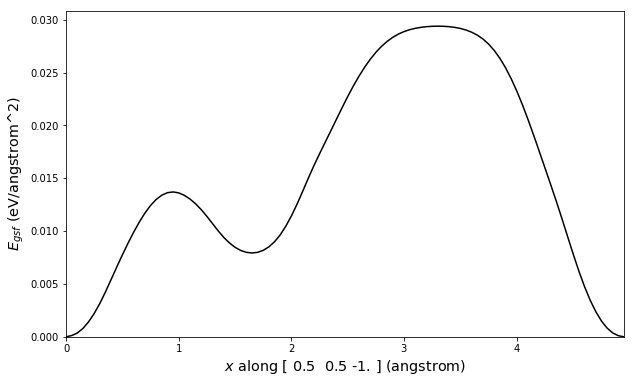

In [8]:
fig = gamma.E_gsf_line_plot(vect=gamma.a2vect)
plt.show()

**E_gsf_surface_plot()** Creates a 2D surface plot from the stacking fault energy values.
        
Parameters
        
- **normalize** (*bool, optional*) Flag indicating if axes are Cartesian (False, default) or normalized by a1, a2 vectors (True).
            
- **smooth** (*bool, optional*) If True (default), then plot shows smooth interpolated values.  If False, plot shows nearest raw data values.

- **xvect** (*numpy.array, optional*) Crystal vector to align with the plotting x-axis for non-normalized plots.  If not given, this is taken as the object's a1vect.

- **length_unit** (*str, optional*) The unit of length to display non-normalized axes values in.  Default value is 'angstrom'.

- **energyperarea_unit** (*str, optional*) The unit of energy per area to display the stacking fault energies in. Default value is 'eV/angstrom^2'.

- **numx** (*int, optional*) The number of plotting points to use along the x-axis.  Default value is 100.

- **numy** (*int, optional*) The number of plotting points to use along the y-axis.  Default value is 100.

- **xsize** (*float or None, optional*) Base size in inches for the plot's x dimensions.  If None (default), the value is scaled relative to ysize based on the axes vectors.  If both size parameters are None, the larger of the two is set to 10.

- **ysize** (*float or None, optional*) Base size in inches for the plot's y dimensions.  If None (default), the value is scaled relative to xsize based on the axes vectors.  If both size parameters are None, the larger of the two is set to 10.

- **cmap** (*str*) matplotlib colormap name to use.
            
Returns
        
- (*matplotlib.figure*)

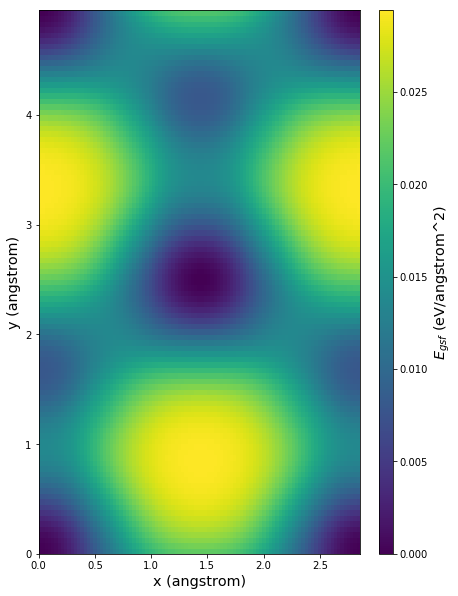

In [9]:
fig = gamma.E_gsf_surface_plot()
plt.show()

## 3. Generate initial disregistry

Solving the SDVPN model requires starting with an initial guess of the disregistry. 

**pn_arctan_disregistry()**

The atomman.defect.pn_arctan_disregistry() function computes the classic Peierls-Nabarro arctan disregistry for an array of points x
        
$$ \delta_i(x) = \frac{b}{\pi} \arctan{ \left( \frac{x}{\xi} \right)} + \frac{b_i}{2} $$

where $\xi$ is the dislocation's halfwidth and $b_i$ is the Burgers vector.

Parameters
    
- **xmax** (*float or None, optional*) Maximum value of x to use.  Minimum value is taken as -xmax.  At least 2 of xmax, xstep, and xnum must be not None.  Default value is None.

- **xstep** (*float or None, optional*) Step size to use between each x value.  At least 2 of xmax, xstep, and xnum must be not None.  Default value is None.
        
- **xnum** (*int or None, optional*) Number of x values to use.  At least 2 of xmax, xstep, and xnum must be not None.  Default value is None.
        
- **burgers** (*numpy.ndarray, optional*) The Burgers vector for the dislocation. Default value is [1, 0, 0].
        
- **halfwidth** (*float, optional*) The dislocation halfwidth to use. Default value is 1.
        
- **normalize** (*bool, optional*) If True (default), the disregistry values will be scaled such that the two endpoints differ by exactly one Burgers vector.
        
- **shift** (*bool, optional*) If True (default), the disregistry will range [0, 0, 0] to burgers.  If False, the disregistry will range from -burgers to burgers.
        
Returns

- **x** (*numpy.ndarray*) The x-coordinates for the disregistry values.
        
- **disregistry** (*numpy.ndarray*) The disregistry vector at each x-coordinate.

**NOTE:** the parameters normalize and shift should both be True for use with the SDVPN model.

In [10]:
# Transform Burgers vector to axes
transform = am.tools.axes_check(np.array([x_axis, y_axis, z_axis]))
b = transform.dot(burgers)
print('Transformed Burgers vector =', b)

Transformed Burgers vector = [2.86045906 0.         0.        ]


In [11]:
# Generate disregistry
xstep = a * 2**0.5 / 4  # atomic column separation along [10-1] direction
xnum = 100
halfwidth = 2

x, disreg = am.defect.pn_arctan_disregistry(xstep=xstep, xnum=xnum, burgers=b, halfwidth=halfwidth)

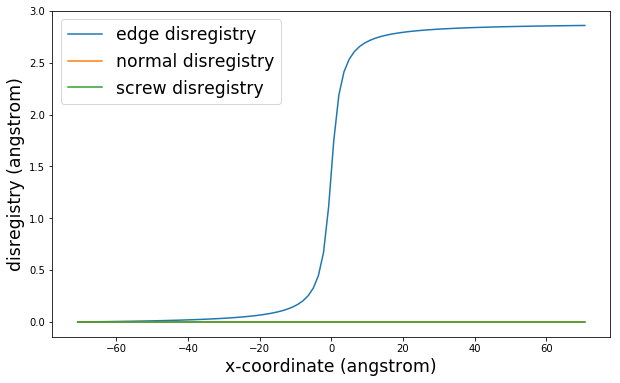

In [12]:
fig = plt.figure(figsize=(10,6))
plt.plot(x, disreg[:, 0], label='edge disregistry')
plt.plot(x, disreg[:, 1], label='normal disregistry')
plt.plot(x, disreg[:, 2], label='screw disregistry')
plt.legend(fontsize='xx-large')
plt.xlabel('x-coordinate (angstrom)', size='xx-large')
plt.ylabel('disregistry (angstrom)', size='xx-large')
plt.show()

## 4. Solve SDVPN model

A solution for the SDVPN model will be obtained through minimization upon initializing an object of the SDVPN class.  There are numerous parameters that can be set.

Parameters
        
- **x** (*numpy.ndarray*) An array of shape (N) giving the x coordinates corresponding to the disregistry solution.

- **disregistry** (*numpy.ndarray*) A (N,3) array giving the initial disregistry vector guess at each x coordinate.

- **gamma** (*atomman.defect.GammaSurface*) The gamma surface (stacking fault map) to use for computing the misfit energy.

- **axes** (*numpy.ndarray*) A (3,3) array defining the crystal directions of the dislocation system. Used to orient the disregistry vector to the gamma surface in computing the misfit energy.

- **K_tensor** (*numpy.ndarray*) A (3,3) array giving the anisotropic elastic energy coefficients corresponding to the dislocation system's orientation.  Can be computed with atomman.defect.Stroh.

- **tau** (*numpy.ndarray, optional*) A (3,3) array giving the stress tensor to apply to the system using the stress energy term.  Only the xy, yy, and yz components are used.  Default value is all zeros.

- **alpha** (*list of float, optional*) The alpha coefficient(s) used by the nonlocal energy term.  Default value is [0.0].

- **beta** (*numpy.ndarray, optional*) The (3,3) array of beta coefficient(s) used by the gradient energy term.  Default value is all zeros.

- **cutofflongrange** (*float, optional*) The cutoff distance to use for computing the long-range energy.  Default value is 1000 Angstroms.

- **burgers** (*numpy.ndarray, optional*) The (3,) array of the dislocation's Burgers vector relative to the dislocation system.  Used only by the long-range energy.  Default value is all zeros (long-range energy will be excluded).

- **fullstress** (*bool, optional*) Flag indicating which stress energy algorithm to use.  Default value is True.

- **cdiffelastic** (*bool, optional*) Flag indicating if the dislocation density for the elastic energy component is computed with central difference (True) or simply neighboring values (False).  Default value is False.

- **cdiffsurface** (*bool, optional*) Flag indicating if the dislocation density for the surface energy component is computed with central difference (True) or simply neighboring values (False).  Default value is True.

- **cdiffstress** (*bool, optional*) Flag indicating if the dislocation density for the stress energy component is computed with central difference (True) or simply neighboring values (False).  Only matters if fullstress is True.  Default value is False.

- **min_method** (*str, optional*) The scipy.optimize.minimize method to use.  Default value is 'Powell'.

- **min_options** (*dict, optional*) Any options to pass on to scipy.optimize.minimize. Default value is {}.

**Execution tips:** Tests seem to indicate that the 'Powell' minimization option works well for this problem.  For best results, use min_options to set xtol and ftol to smaller values and run the solver multiple times in a row (minimizer may get stuck).

Set parameters and solve the first time

In [13]:
min_options = {}
min_options['disp'] = True # will display convergence info
min_options['xtol'] = 1e-6 # smaller convergence tolerance than default
min_options['ftol'] = 1e-6 # smaller convergence tolerance than default
#min_options['maxiter'] = 2 # for testing purposes
pnsolution = am.defect.SDVPN(x=x, disregistry=disreg, gamma=gamma, 
                             axes=np.array([x_axis, y_axis, z_axis]), K_tensor=K_tensor,
                             min_options=min_options)

Optimization terminated successfully.
         Current function value: -0.097610
         Iterations: 13
         Function evaluations: 38530


Values for the different energy terms can be obtained and the disregistry plotted.

Dislocation energy terms in eV/angstrom:
Misfit energy =     0.15867522311411947
Elastic energy =    -0.25628551352616935
Long-range energy = 0.0
Stress energy =     -0.0
Surface energy =    0.0
Nonlocal energy =   0.0
Total energy =      -0.09761029041204988


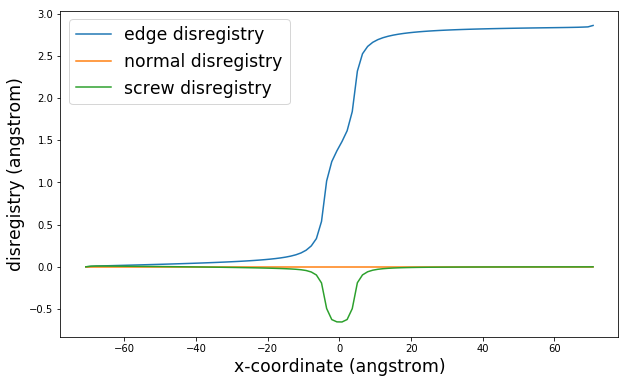

In [14]:
print('Dislocation energy terms in eV/angstrom:')
print('Misfit energy =    ', pnsolution.misfit_energy())
print('Elastic energy =   ', pnsolution.elastic_energy())
print('Long-range energy =', pnsolution.longrange_energy())
print('Stress energy =    ', pnsolution.stress_energy())
print('Surface energy =   ', pnsolution.surface_energy())
print('Nonlocal energy =  ', pnsolution.nonlocal_energy())
print('Total energy =     ', pnsolution.total_energy())

fig = plt.figure(figsize=(10,6))
plt.plot(pnsolution.x, pnsolution.disregistry[:, 0], label='edge disregistry')
plt.plot(pnsolution.x, pnsolution.disregistry[:, 1], label='normal disregistry')
plt.plot(pnsolution.x, pnsolution.disregistry[:, 2], label='screw disregistry')
plt.legend(fontsize='xx-large')
plt.xlabel('x-coordinate (angstrom)', size='xx-large')
plt.ylabel('disregistry (angstrom)', size='xx-large')
plt.show()

Call solve() to run the solver again, using the current disregistry solution as the input disregistry.  All other parameters are left unchanged unless they are given.

In [15]:
for i in range(10):
    pnsolution.solve()

Optimization terminated successfully.
         Current function value: -0.097610
         Iterations: 1
         Function evaluations: 4067
Optimization terminated successfully.
         Current function value: -0.097610
         Iterations: 1
         Function evaluations: 4477
Optimization terminated successfully.
         Current function value: -0.097610
         Iterations: 1
         Function evaluations: 4621
Optimization terminated successfully.
         Current function value: -0.097610
         Iterations: 1
         Function evaluations: 4747
Optimization terminated successfully.
         Current function value: -0.097610
         Iterations: 1
         Function evaluations: 4985
Optimization terminated successfully.
         Current function value: -0.097610
         Iterations: 1
         Function evaluations: 4973
Optimization terminated successfully.
         Current function value: -0.097610
         Iterations: 1
         Function evaluations: 5085
Optimization termina

Dislocation energy terms in eV/angstrom:
Misfit energy =     0.1587051325257367
Elastic energy =    -0.25631549289628597
Long-range energy = 0.0
Stress energy =     -0.0
Surface energy =    0.0
Nonlocal energy =   0.0
Total energy =      -0.09761036037054927


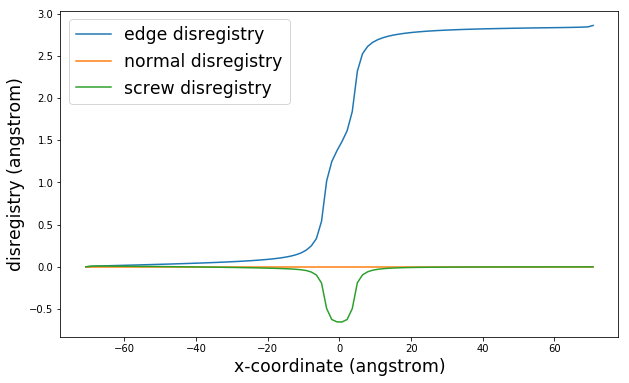

In [16]:
print('Dislocation energy terms in eV/angstrom:')
print('Misfit energy =    ', pnsolution.misfit_energy())
print('Elastic energy =   ', pnsolution.elastic_energy())
print('Long-range energy =', pnsolution.longrange_energy())
print('Stress energy =    ', pnsolution.stress_energy())
print('Surface energy =   ', pnsolution.surface_energy())
print('Nonlocal energy =  ', pnsolution.nonlocal_energy())
print('Total energy =     ', pnsolution.total_energy())

fig = plt.figure(figsize=(10,6))
plt.plot(pnsolution.x, pnsolution.disregistry[:, 0], label='edge disregistry')
plt.plot(pnsolution.x, pnsolution.disregistry[:, 1], label='normal disregistry')
plt.plot(pnsolution.x, pnsolution.disregistry[:, 2], label='screw disregistry')
plt.legend(fontsize='xx-large')
plt.xlabel('x-coordinate (angstrom)', size='xx-large')
plt.ylabel('disregistry (angstrom)', size='xx-large')
plt.show()

Plot disregistry path on the gamma surface

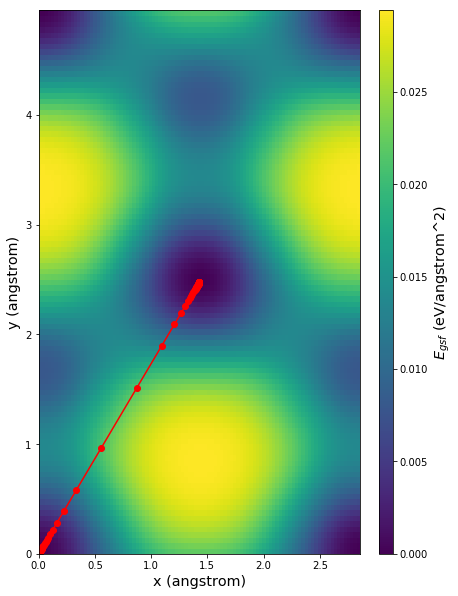

In [17]:
x, y = gamma.pos_to_xy(disreg.dot(transform))
fig = gamma.E_gsf_surface_plot()
plt.plot(x, y, 'ro-')